<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/nlp/%5Bclassify%5D_attention_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## attention layer

Best Model:



#library and installation

In [1]:


!pip install keras-self-attention

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-avUDygRCGvAiPplmc6MundS_PpnohRv
To: /content/preprocessed_v1_socialfsi_single_train_sampling12150_20220701.xlsx
100% 3.87M/3.87M [00:00<00:00, 264MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=106OVRPIQQBppganRnCZigxQh6-Zyvqit
To: /content/preprocessed_v1_socialfsi_single_test_sampling389_20220701.xlsx
100% 141k/141k [00:00<00:00, 84.2MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: fil

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
train = pd.read_excel('/content/preprocessed_v1_socialfsi_single_train_sampling12150_20220701.xlsx')
test = pd.read_excel('/content/preprocessed_v1_socialfsi_single_test_sampling389_20220701.xlsx')

In [4]:
train.head(1)

,Unnamed: 0,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local
0,0,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling2244_2022...,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling1400_2022...,Krungthai_NEXT,"mobile banking+กสิกร,mobile banking+ธนาคารกสิก...",SocialMedia,forum,pantip.com_topic_41249919,Q2207_1549,Q2207_1549_1,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,"Product and Service, Usage and Condition",8,neutral,o,สอบถาม|เรื่อง|การ|อายัด|บัตรเดบิต|ของ|kbank|ค่...


In [5]:
test.head(1)

,Unnamed: 0,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local
0,0,SocialFSI_v4_0_mutiple_train_sampling8203_2021...,SocialFSI_SV-FSI-20201101-29-20201201-25_Sampl...,NaN,NaN,SocialMedia,Pantip,5fdb2543b08b582c303ceba3,Q202106_4598,Q202106_4598_1,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,"Product and Service, Variety",10,neutral,o,ในอนาคต|ธนาคาร|kk|ภัทร|จะ|มี|บัตรเครดิต|ไหม|คร...


#create a vocabulary

In [6]:
from collections import Counter

vocab = Counter()
def data_to_vocab(df):
  for verbatim in df['Text_ws_local']:
    tokens = verbatim.split()
    tokens = [word for word in tokens if len(tokens) > 4] #at first = 1, CNN GMP is better with >4 for ~2%
    vocab.update(tokens)

data_to_vocab(train)

print(len(vocab))
vocab.most_common(20)

46943


[('|scb|', 1518),
 ('|friendtag|', 625),
 ('|2|', 512),
 ('|kbank|', 403),
 ('|บาท|', 360),
 ('|1|', 340),
 ('|3|', 329),
 ('|5|', 298),
 ('|tmb|', 251),
 ('|call_center|', 250),
 ('|atm|', 249),
 ('atm|', 245),
 ('|scb_easy|', 201),
 ('|telephonetag|', 199),
 ('|app|', 199),
 ('|กรุงไทย|', 198),
 ('|-|', 184),
 ('|sms|', 178),
 ('|ktc|', 176),
 ('|ของ|', 164)]

In [7]:
min_occurence = 2
tokens = [k for k, c in vocab.items() if c >= min_occurence]

In [8]:
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
  
save_list(tokens, 'vocab.txt')

#preprocessing

In [9]:
#Load the vocab as above
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

print(vocab)

{'|มี|.|ค.|', '|ก็ได้|', '|โยน|กัน|ไป|โยน|กัน|มา|', '|kjourney|', '|กลัว|โดน|หลอก|', 'กัน|', '|baac|', '|เรา|', '|fb|', '|ไง|', 'k|', '|ขออภัย|', '|ยอดเงิน|', '|สาขา|', '|18|', '3|1|', '|ltf|', '|tmb_so_smart|', '|เงิน|หัก|จาก|บัญชีธนาคาร|แล้วแต่|ยอด|ใน|แอป|เป๋า|ตัง|ยัง|เป็น|', 'กู้เงิน|กับ|', '|ต่อ|เดือน|', '|เม.ย|', '|1.|', '|ของ|bay|', '|แล้ว|นะ|', '|โต|ขึ้นมา|คุณ|เลย|เป็น|คน|รู้จัก|อดทนอดกลั้น|', '|10.32|', '|เติม|จาก|', '|ถ้า|ยื่น|กู้|กับ|', '|รอบ|', '|จ่าย|ดอก|ทุกเดือน|', '|แต่กลับ|ไม่มีใคร|โทร|มา|ทวง|เลย|กลับเป็น|ส่ง|', '|ธนาคาร', 'พึ่ง|รู้ว่า|', '|เลข|บัตรประชาชน|', '|จ้า', '|ไม่สามารถ|เข้า|', '|ล้าน|', '|จน|เรา|ติดต่อ|เข้าไป|เป็น|ครั้ง|ที่', '|ใช้เวลา|ประมาณ|', '|ไม่ได้|นับจำนวน|ครั้ง|ตาม|ลูกค้า|แต่ละคน|โอน|', '|flow|', '|ต้อง|ทำ|ยังไง|', '|มี|นา|', '|1.3|', 'อยาก|สอบถาม|ว่า|', 'เรียน|', '|ผม|เปิดบัญชี|ตั้งแต่|วัน|ที่', '|ธนาคารอาคารสงเคราะห์|', '|smebank|', '|อัพ|', '|พร้อมเพย์|', '|คำถาม|', '|เมษายน|', '|ตัวเอง|', '|pbv|', '|amount|', '|มีโอกาส|', '|got|7|keepspinninginbkk',

In [10]:
#Turn Series into lists
train_docs = train['Text_ws_local'].tolist()
test_docs = test['Text_ws_local'].tolist()

In [11]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
#one hot-enconding for the text like > https://stackoverflow.com/questions/69026891/what-is-keras-tokenizer-fit-on-texts-doing
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)

In [12]:
#Find the most max lengths of word in verbatims from both train and test
max_length_train = max([len(s.split()) for s in train_docs])
max_length_test  = max([len(s.split()) for s in test_docs])
max_length = max([max_length_train, max_length_test])
print("Max Length of Words: ", max_length)

#Padding in order to equalize some verbatims that do not contain the same length of the max length verbatim
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
#define the labels
ytrain = np.array(train['Human_CategoryID'].tolist())

Max Length of Words:  66


In [13]:
#Do the same for the test set
encoded_docs_test = tokenizer.texts_to_sequences(test_docs)

Xtest = pad_sequences(encoded_docs_test, maxlen=max_length)
ytest = np.array(test['Human_CategoryID'].tolist())

In [14]:
#Count unique classes
print(train['Human_CategoryID'].nunique(), test['Human_CategoryID'].nunique())

13 12


In [15]:
#Count unique classes
num_classes = max(train['Human_CategoryID'].nunique(), test['Human_CategoryID'].nunique())
print(num_classes)

13


In [16]:
from tensorflow.keras.utils import to_categorical

#Multi class problems need one-hot encoding on y
#why - 1 on ytrain and ytest? can follow the linke below
#https://stackoverflow.com/questions/56204731/the-method-np-utils-to-categorical-give-me-an-error/59002957#59002957
ytrain =  to_categorical(ytrain-1, num_classes=num_classes)
ytest = to_categorical(ytest-1, num_classes=num_classes)

In [17]:
vocab_size = len(tokenizer.word_index)+1

#model
*   add class_weights:  lower acc
*   add mark_zero in EBL: higher acc



transformer explained: https://youtu.be/TQQlZhbC5ps

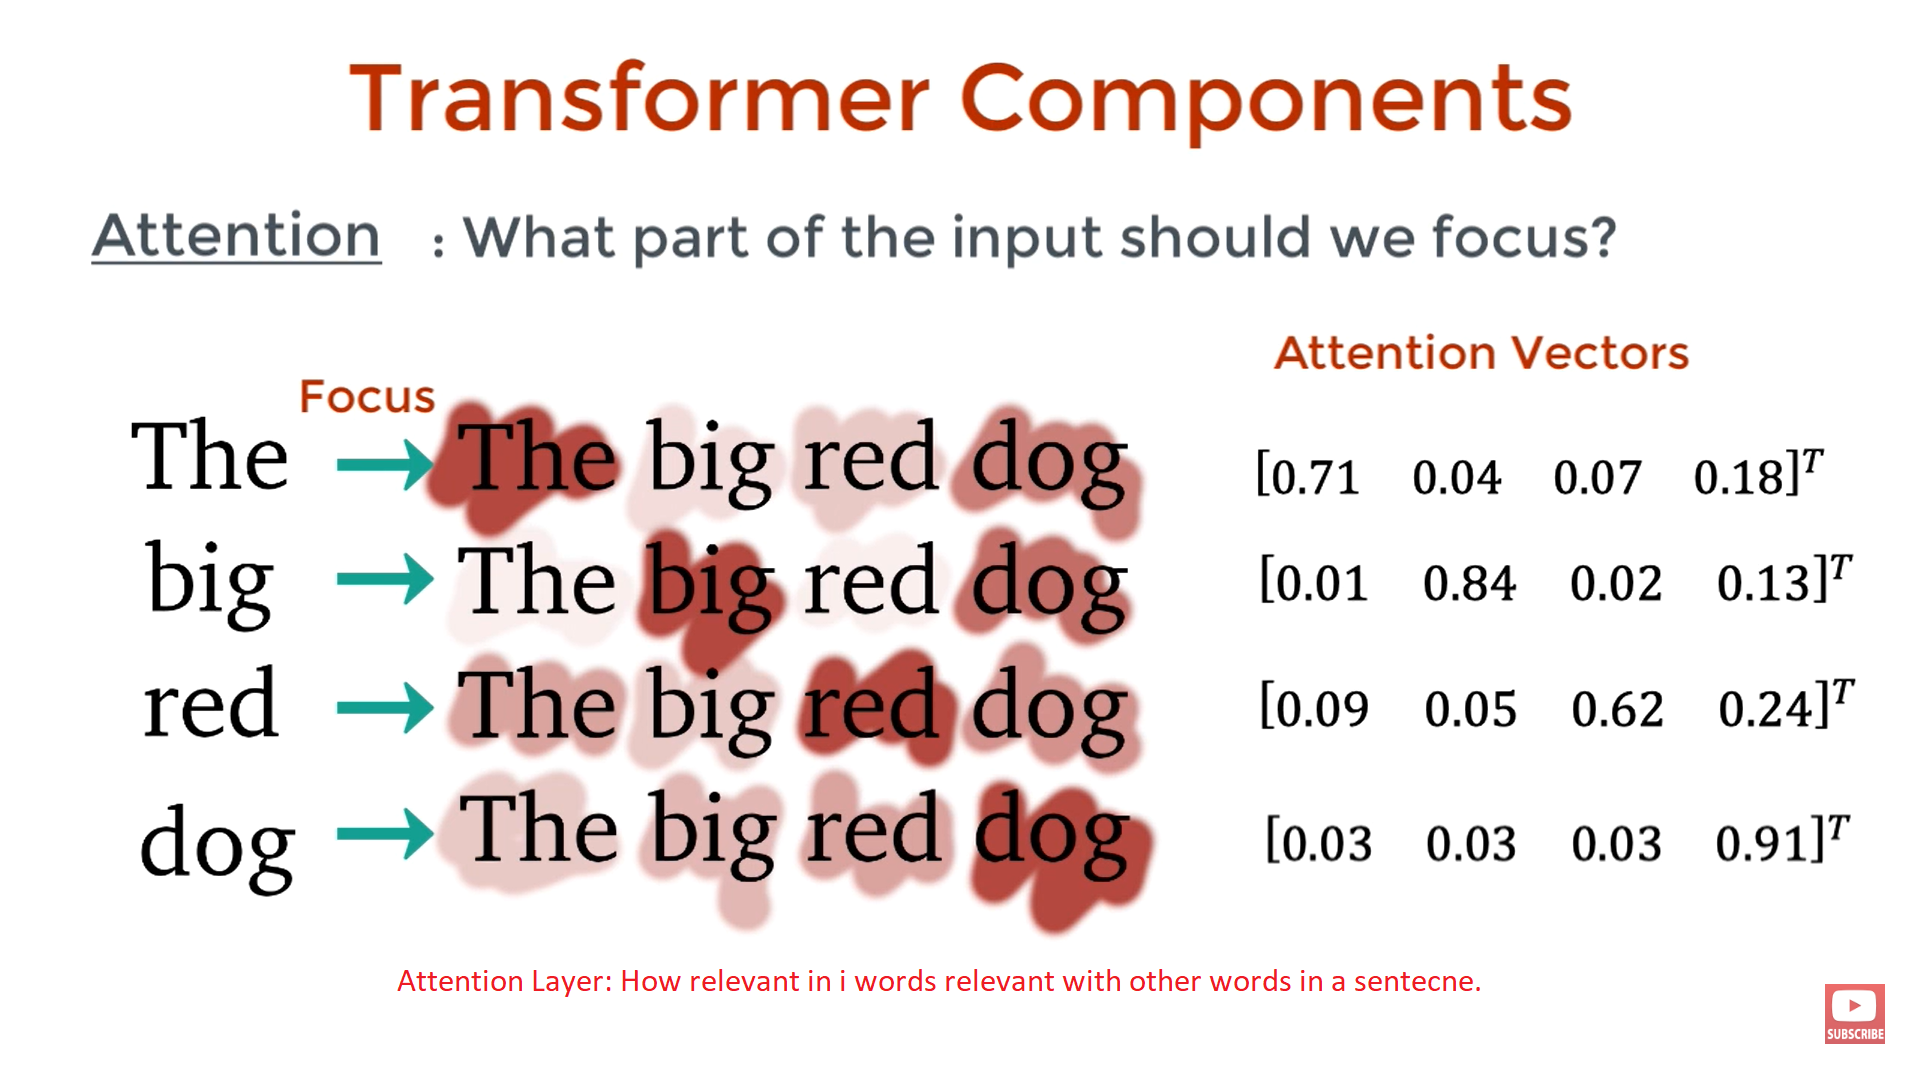

##[SeqSelfAttention] EL800M0 BILSTM512 SSA AP1D F D13: 65

https://datascience.stackexchange.com/questions/89884/the-use-of-keras-self-attention-module

EL100 BILSTM128 M0.0 SSA F D13: 56

EL100M0 BILSTM128 SSA F D13: 62

EL100M0 BILSTM128 SSA AP1D F D13: 62-63

EL200M0 LSTM128 SSA D13: 60

EL200M0 BiLSTM256 M0.0 SSA F D13: 62

EL200M0 BiLSTM256 M0.0 SSA AP1D F D13: 62

EL400M0 BILSTM128 SSA AP1D F D13: 61

EL600M0 BiLSTM256 M0.0 SSA F D13: 61

EL800M0 BILSTM64 SSA AP1D F D13:59

EL800M0 BILSTM256 SSA AP1D F D13:60

EL800M0 BILSTM128 SSA AP1D F D13: 64

EL800M0 BILSTM1024 SSA AP1D F D13:59

EL1000M0 BILSTM128 SSA AP1D F D13: 62

EL1200M0 BILSTM128 SSA AP1D F D13: 61

EL1200M0 M0.0 BILSTM128 SSA AP1D F D13: 61

EL1200M0 BILSTM128 M0.0 SSA AP1D F D13:62

In [183]:
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import Input
from keras.models import Sequential, Model
from keras_self_attention import SeqSelfAttention
from keras.layers.pooling import GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout,Bidirectional,Masking,LSTM, Embedding, Flatten, concatenate, Conv1D

In [184]:
model = Sequential()
model.add(Embedding(vocab_size, 800, input_length=max_length, trainable=True, mask_zero=True))
model.add(Bidirectional(LSTM(units=512, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(AveragePooling1D()) 

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 66, 800)           10087200  
                                                                 
 bidirectional_30 (Bidirecti  (None, 66, 1024)         5378048   
 onal)                                                           
                                                                 
 seq_self_attention_31 (SeqS  (None, 66, 1024)         65601     
 elfAttention)                                                   
                                                                 
 average_pooling1d_17 (Avera  (None, 33, 1024)         0         
 gePooling1D)                                                    
                                                                 
 flatten_31 (Flatten)        (None, 33792)             0         
                                                     

In [185]:
from tensorflow.keras.callbacks import EarlyStopping

#put early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min')

#Your choices of activation='softmax' in the last layer and compile choice of loss='categorical_crossentropy' 
#are good for a model to predict multiple mutually-exclusive classes.

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],)

In [186]:
#when using class weights, it reduced acc significantly.

history = model.fit(Xtrain, ytrain, 
                    epochs=10, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping],)

Epoch 1/10
152/152 [==============================] - 398s 3s/step - loss: 1.4040 - acc: 0.5399 - val_loss: 1.1535 - val_acc: 0.6148
Epoch 2/10
152/152 [==============================] - 367s 2s/step - loss: 0.7982 - acc: 0.7424 - val_loss: 1.1814 - val_acc: 0.6140


In [187]:
loss, acc = model.evaluate(Xtest, ytest)
print('Test Accuracy: %f' % (acc*100))

13/13 [==============================] - 5s 384ms/step - loss: 1.1818 - acc: 0.6427
Test Accuracy: 64.267349


#classification report and confusion matrix

In [161]:
from tensorflow.keras.utils import plot_model

In [162]:
#prediction
y_pred = model.predict(Xtest)

#Change one hot answer to be single digit as follows 
#https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel

rounded_labels_ypred = np.argmax(y_pred, axis=1)
rounded_labels_ytest = np.argmax(ytest,axis=1)

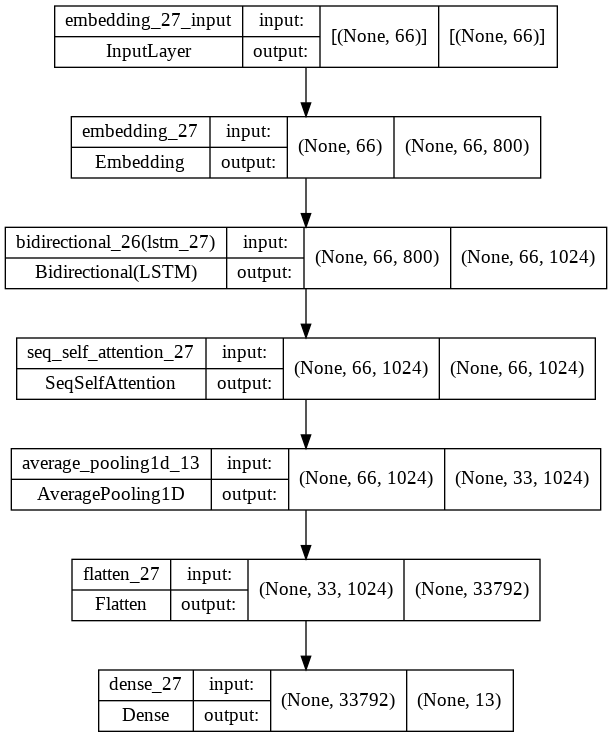

In [163]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from google.colab import files
# files.download('model_plot.png')

In [164]:
#Find dict of label ids and names.
if train['Human_CategoryID'].nunique() < test['Human_CategoryID'].nunique():
  print('train_unique_classes')
  classes_with_id_dict = {id-1: labels for id, labels in zip(train['Human_CategoryID'], train['Human_Category'])}
  print(len(classes_with_id_dict))
else:
  print('test_unique_classes')
  classes_with_id_dict = {id-1: labels for id, labels in zip(test['Human_CategoryID'], test['Human_Category'])}
  print(len(classes_with_id_dict))

classes_with_id_dict

test_unique_classes
12


{0: 'Accessibility',
 2: 'Company Brand',
 3: 'Staff Quality',
 4: 'Timing',
 5: 'Product and Service, Benefit',
 6: 'Product and Service, System',
 7: 'Product and Service, Usage and Condition',
 8: 'Product and Service, Convenience',
 9: 'Product and Service, Variety',
 10: 'Product and Service, Decision',
 11: 'Security',
 12: 'No Category'}

In [165]:
#get an labels array in the conseuctive order based on id number.
train_unique_classes = train['Human_CategoryID'].nunique()
test_unique_classes = test['Human_CategoryID'].nunique()

#find the label total
if train['Human_CategoryID'].nunique() > test['Human_CategoryID'].nunique():
  print('test_unique_classes')
  classes_with_id = test_unique_classes
else:
  print('train_unique_classes')
  classes_with_id = train_unique_classes

#convert a dict to an array
classes_array = ["" for x in range(classes_with_id+1)]

for id, label in classes_with_id_dict.items():
  classes_array[id] = label

#delete empty string for classification report
classes_array = [label for label in classes_array if label != ""]
classes_array
print(len(classes_array))

test_unique_classes
12


In [166]:
from sklearn.metrics import classification_report

print(classification_report(rounded_labels_ytest, rounded_labels_ypred, target_names=classes_array, zero_division=0))

                                          precision    recall  f1-score   support

                           Accessibility       0.60      0.43      0.50         7
                           Company Brand       0.36      0.42      0.38        12
                           Staff Quality       0.50      0.47      0.48        17
                                  Timing       0.62      0.75      0.68        28
            Product and Service, Benefit       0.67      0.56      0.61        32
             Product and Service, System       0.70      0.87      0.77        84
Product and Service, Usage and Condition       0.70      0.61      0.65        92
        Product and Service, Convenience       1.00      0.45      0.62        11
            Product and Service, Variety       0.38      0.50      0.43        12
           Product and Service, Decision       0.60      0.30      0.40        10
                                Security       0.50      0.33      0.40         3
               

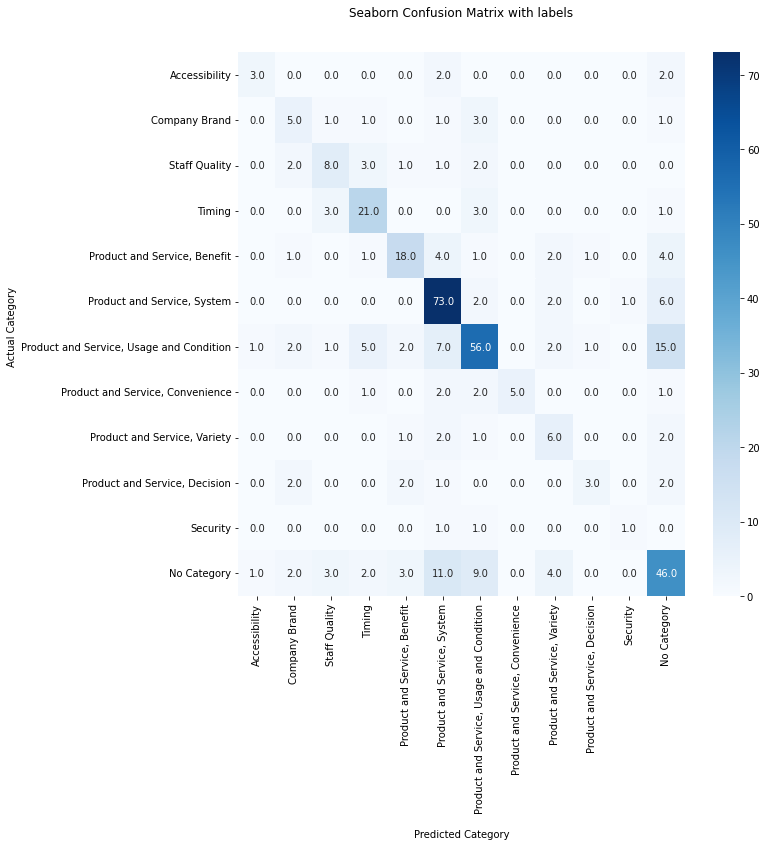

In [167]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(rounded_labels_ytest, rounded_labels_ypred)

fig, ax = plt.subplots(figsize=(10,10))    
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax, fmt=".1f")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_array, rotation=90)
ax.yaxis.set_ticklabels(classes_array, rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

figure = ax.get_figure()    
figure.savefig("cf_matrix.png", pad_inches= 12, dpi=400)